#**前置作業**

##引入模組

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openpyxl
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers import Dense, Conv1D, LSTM, MaxPooling1D, Flatten, Dropout
from sklearn.svm import SVR
from keras.models import load_model


##定義參數

In [ ]:
# 檔案、資料夾路徑參數
gdrive_path = '/content/drive' # 雲端硬碟路徑
project_folder_path = '/content/drive/MyDrive/Inundation_Forcasting/' # 專案資料夾的路徑
filename = 'SD.xlsx' # 資料檔案名稱
data_source_path = project_folder_path + 'data/' # 存放資料的資料夾路徑
data_source = data_source_path + filename # 資料檔案的完整路徑
weights_path = project_folder_path + 'weights/' # 權重檔的資料夾路徑
output_path = project_folder_path + 'outputs/' # 輸出結果的資料夾路徑

num_events = 5

# 模型參數
epochs = 50 # 迭代次數(要讓模型看幾次訓練資料)
batch_size = 16 # 批次大小(每看多少筆資料更新一次權重)
learning_rate = 0.001 # 學習速率
loss_fn = 'mse' # 損失函數


##連接雲端硬碟

In [ ]:
from google.colab import drive
drive.mount(gdrive_path)

Mounted at /content/drive


#**副程式**

##資料處理工具

In [ ]:
# 載入資料
def load_data(path):
    wb = openpyxl.load_workbook(path, data_only=True)
    events = [wb[sheetname] for sheetname in wb.sheetnames]
    for i in range(len(events)):
        events[i] = pd.DataFrame(get_values(events[i]))
    return events

# 取得資料值並儲存為列表
def get_values(sheet):
    arr = [] 
    for row in sheet:
        temp = []  
        for column in row:
            temp.append(column.value)
        arr.append(temp)
    return arr

# 正規化資料(將資料範圍限縮在0~1之間，防止資料大小差異過大，影響模型訓練)
def normalize(data):
    normalized_data = (data - np.min(data)) / (np.max(data) - np.min(data))
    return normalized_data

# 反正規化資料(將正規化的資料還原，用於結果呈現)
def denormalize(data, original):
    denormalized_data = data * (np.max(original) - np.min(original)) + np.min(original)
    return denormalized_data

# 分割訓練及測試資料
def split_data(X, Y, split_boundary):
    X_train = X[:split_boundary]
    Y_train = Y[:split_boundary]
    X_test = X[split_boundary:]
    Y_test = Y[split_boundary:]
    return X_train, Y_train, X_test, Y_test

# 產生可輸入模型的資料及標籤
def create_sequences(events):
    df = pd.concat(events, ignore_index=True)
    ref = df.iloc[:, :(len(df.columns)-1)] # 取得第一欄~倒數第二欄的資料為參考資料
    pred = df.iloc[:, (len(df.columns)-1)] # 以最後一欄的資料為目標資料

    X, Y = [], []
    num_data = len(ref)
    for i in range(num_data):
        seq = ref.iloc[i, :]
        label = pred[i]
        X.append(seq)
        Y.append(label)

    X, Y = np.array(X), np.array(Y)
    X = X.reshape(X.shape[0], X.shape[1], 1).astype('float32')
    Y = Y.reshape(Y.shape[0], 1).astype('float32')

    return X, Y


##定義模型

###LSTM

In [ ]:
class My_LSTM():
  def __init__(self):
    self.name = 'My_LSTM'

  # 創建模型(呼叫以下的train函式時會自動創建)
  def create_model(self, steps, features):
    model = Sequential(name="My_LSTM")
    model.add(LSTM(64, return_sequences=True, input_shape=(steps, features)))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(64))
    model.add(Dense(features))
    return model

  # 訓練模型
  def train(self, data, show_training_history=True):
    X, Y, X_train, Y_train, X_test, Y_test = data
    model = self.create_model(X_train.shape[1], X_train.shape[2])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss_fn)
    history = model.fit(X_train, Y_train, 
                epochs = epochs, 
                batch_size = batch_size, 
                validation_data = (X_test, Y_test)) # 以測試資料為驗證資料
                
    if show_training_history:
      plt.plot(history.history['loss'], label='train')
      plt.plot(history.history['val_loss'], label='val')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.legend()
      plt.show()
    return model

  # 儲存模型
  def save_model(self, model, filename):
    path = weights_path + filename + '.h5'
    model.save(path)
    print('training weights saved in ' + path)

  # 預測結果
  def predict(self, data, filename):
    X, Y, X_train, Y_train, X_test, Y_test = data
    model = load_model(weights_path + filename + '.h5')
    Y_predict = model.predict(X_test)
    Y_predict = denormalize(Y_predict, Y)
    Y_test = denormalize(Y_test, Y)
    return (Y_test, Y_predict)

  # 儲存圖表
  def save_result(self, result, filename, show=True):
    Y_test, Y_predict = result
    plt.plot(Y_test, color = 'red', label = 'Real Depth') 
    plt.plot(Y_predict, color = 'blue', label = 'Predicted Depth') 
    plt.title('Depth Prediction')
    plt.xlabel('Time')
    plt.ylabel('Depth (cm)')
    plt.legend()
    path = output_path + filename + '.png'
    plt.savefig(path)
    print('Prediction result saved in ' + path)
    if show:
      plt.show()


#**主程式**

##訓練模型、產生圖表

Epoch 1/50
16/16 [==============================] - 10s 118ms/step - loss: 0.1184 - val_loss: 0.0946
Epoch 2/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0698 - val_loss: 0.0836
Epoch 3/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0700 - val_loss: 0.0751
Epoch 4/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0607 - val_loss: 0.0509
Epoch 5/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0488 - val_loss: 0.0336
Epoch 6/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0537 - val_loss: 0.0688
Epoch 7/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0521 - val_loss: 0.0341
Epoch 8/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0441 - val_loss: 0.0348
Epoch 9/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0412 - val_loss: 0.0311
Epoch 10/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0431 - val_loss: 0.0369
Epoch 1

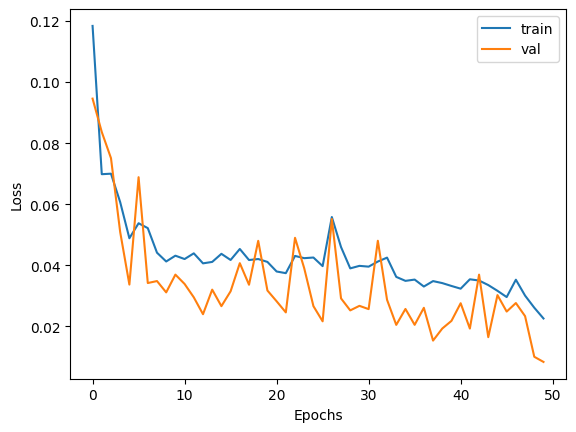

training weights saved in /content/drive/MyDrive/Inundation_Forcasting/weights/SD_training_1.h5
2/2 [==============================] - 1s 9ms/step
Prediction result saved in /content/drive/MyDrive/Inundation_Forcasting/outputs/SD_training_1.png


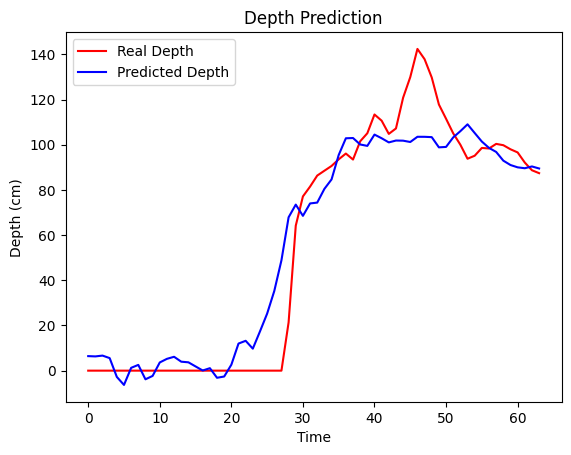

Epoch 1/50
16/16 [==============================] - 6s 93ms/step - loss: 0.1231 - val_loss: 0.0534
Epoch 2/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0890 - val_loss: 0.0404
Epoch 3/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0739 - val_loss: 0.0370
Epoch 4/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0640 - val_loss: 0.0351
Epoch 5/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0447 - val_loss: 0.0466
Epoch 6/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0387 - val_loss: 0.0293
Epoch 7/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0415 - val_loss: 0.0323
Epoch 8/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0403 - val_loss: 0.0588
Epoch 9/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0369 - val_loss: 0.0511
Epoch 10/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0380 - val_loss: 0.0362
Epoch 11/

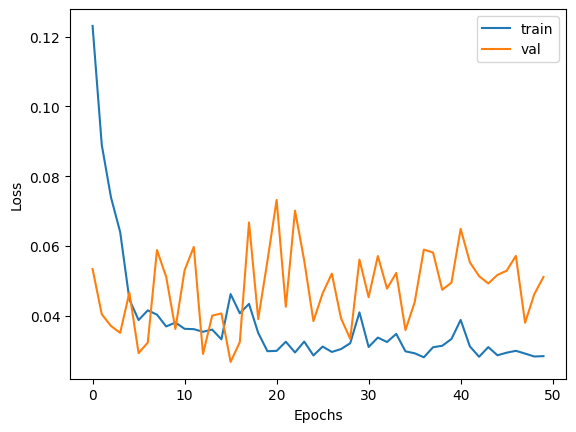

training weights saved in /content/drive/MyDrive/Inundation_Forcasting/weights/SD_training_2.h5
2/2 [==============================] - 2s 9ms/step
Prediction result saved in /content/drive/MyDrive/Inundation_Forcasting/outputs/SD_training_2.png


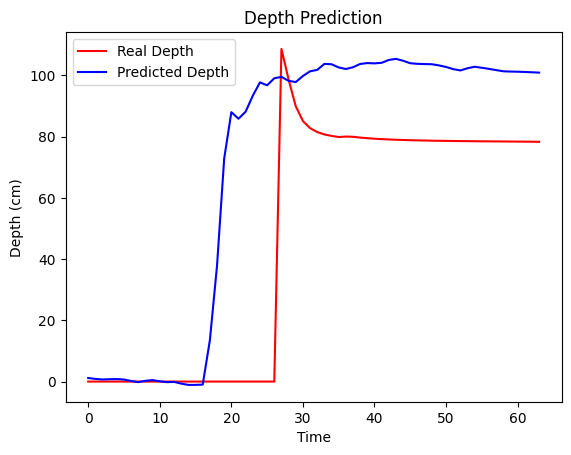

Epoch 1/50
16/16 [==============================] - 5s 89ms/step - loss: 0.1241 - val_loss: 0.0912
Epoch 2/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0728 - val_loss: 0.1698
Epoch 3/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0647 - val_loss: 0.0836
Epoch 4/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0414 - val_loss: 0.0996
Epoch 5/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0294 - val_loss: 0.0808
Epoch 6/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0323 - val_loss: 0.1429
Epoch 7/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0253 - val_loss: 0.1372
Epoch 8/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0287 - val_loss: 0.0888
Epoch 9/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0256 - val_loss: 0.0840
Epoch 10/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0255 - val_loss: 0.0988
Epoch 11/

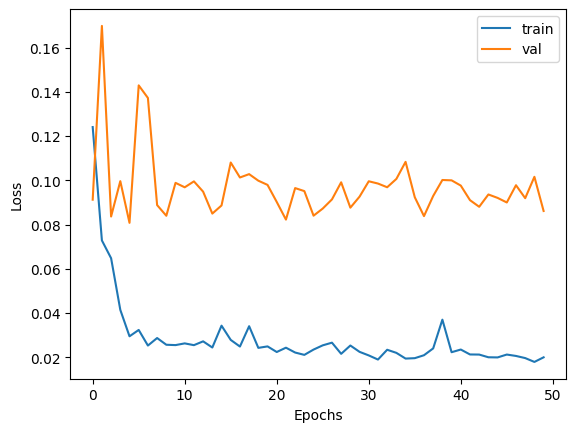

training weights saved in /content/drive/MyDrive/Inundation_Forcasting/weights/SD_training_3.h5
2/2 [==============================] - 1s 11ms/step
Prediction result saved in /content/drive/MyDrive/Inundation_Forcasting/outputs/SD_training_3.png


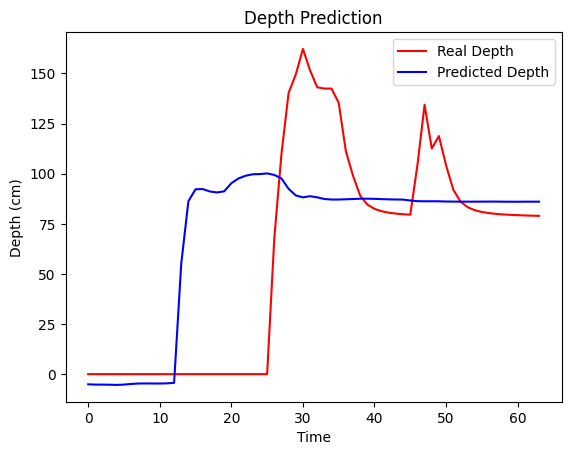

Epoch 1/50
15/15 [==============================] - 6s 98ms/step - loss: 0.1138 - val_loss: 0.0979
Epoch 2/50
15/15 [==============================] - 0s 20ms/step - loss: 0.0716 - val_loss: 0.0638
Epoch 3/50
15/15 [==============================] - 0s 19ms/step - loss: 0.0594 - val_loss: 0.0829
Epoch 4/50
15/15 [==============================] - 0s 19ms/step - loss: 0.0571 - val_loss: 0.0877
Epoch 5/50
15/15 [==============================] - 0s 20ms/step - loss: 0.0522 - val_loss: 0.0286
Epoch 6/50
15/15 [==============================] - 0s 18ms/step - loss: 0.0465 - val_loss: 0.0580
Epoch 7/50
15/15 [==============================] - 0s 18ms/step - loss: 0.0486 - val_loss: 0.0425
Epoch 8/50
15/15 [==============================] - 0s 20ms/step - loss: 0.0478 - val_loss: 0.0320
Epoch 9/50
15/15 [==============================] - 0s 18ms/step - loss: 0.0478 - val_loss: 0.0254
Epoch 10/50
15/15 [==============================] - 0s 18ms/step - loss: 0.0525 - val_loss: 0.0413
Epoch 11/

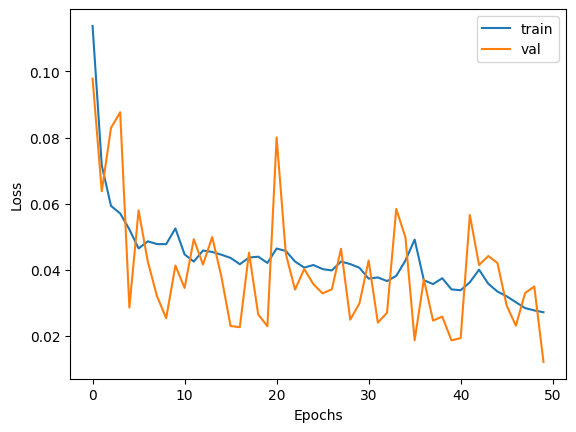

training weights saved in /content/drive/MyDrive/Inundation_Forcasting/weights/SD_training_4.h5
3/3 [==============================] - 1s 7ms/step
Prediction result saved in /content/drive/MyDrive/Inundation_Forcasting/outputs/SD_training_4.png


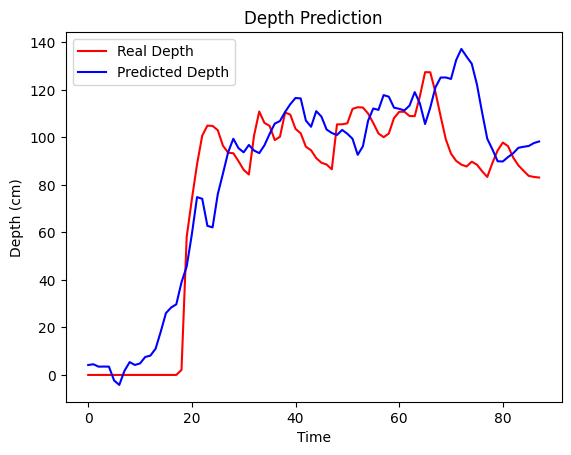

Epoch 1/50
18/18 [==============================] - 8s 82ms/step - loss: 0.1350 - val_loss: 0.1213
Epoch 2/50
18/18 [==============================] - 0s 11ms/step - loss: 0.0875 - val_loss: 0.1102
Epoch 3/50
18/18 [==============================] - 0s 12ms/step - loss: 0.0642 - val_loss: 0.0981
Epoch 4/50
18/18 [==============================] - 0s 12ms/step - loss: 0.0522 - val_loss: 0.0488
Epoch 5/50
18/18 [==============================] - 0s 12ms/step - loss: 0.0410 - val_loss: 0.0756
Epoch 6/50
18/18 [==============================] - 0s 12ms/step - loss: 0.0399 - val_loss: 0.1095
Epoch 7/50
18/18 [==============================] - 0s 12ms/step - loss: 0.0403 - val_loss: 0.0358
Epoch 8/50
18/18 [==============================] - 0s 12ms/step - loss: 0.0372 - val_loss: 0.0749
Epoch 9/50
18/18 [==============================] - 0s 13ms/step - loss: 0.0401 - val_loss: 0.0392
Epoch 10/50
18/18 [==============================] - 0s 12ms/step - loss: 0.0404 - val_loss: 0.0390
Epoch 11/

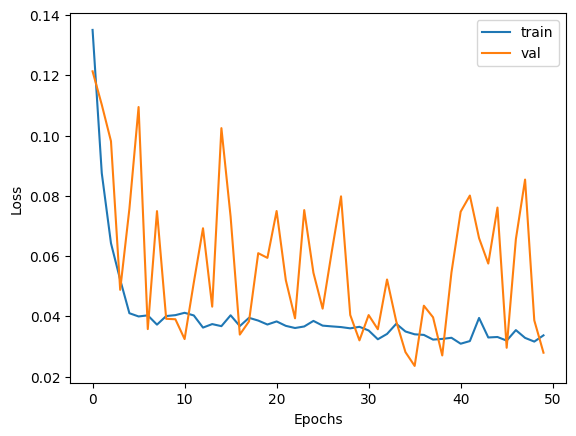

training weights saved in /content/drive/MyDrive/Inundation_Forcasting/weights/SD_training_5.h5


2/2 [==============================] - 1s 10ms/step
Prediction result saved in /content/drive/MyDrive/Inundation_Forcasting/outputs/SD_training_5.png


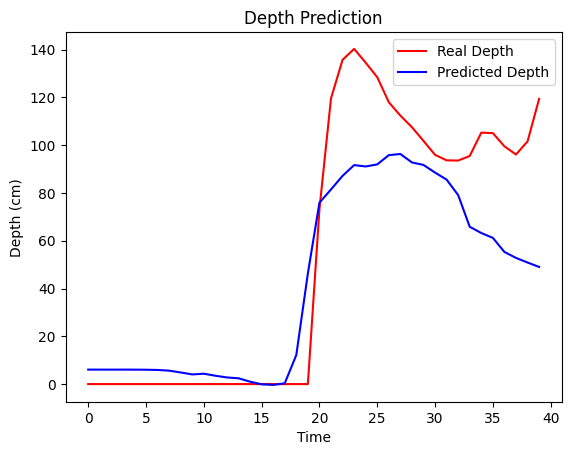

In [ ]:
# 載入資料
events = load_data(data_source)
RES_test = []

# 交叉驗證(使不同事件輪流當測試資料)
for i in range(num_events):

  # 將要作為測試資料的事件移到矩陣尾端，以便分割資料
  temp = events[0]
  events = events[1:]
  split_boundary = sum([len(event) for event in events]) # 計算分割邊界
  events.append(temp)

  # 產生輸入模型的資料
  X, Y = create_sequences(events)
  nX, nY = normalize(X), normalize(Y)
  X_train, Y_train, X_test, Y_test = split_data(nX, nY, split_boundary)
  data = (X, Y, X_train, Y_train, X_test, Y_test)

  # 使用模型進行訓練
  lstm = My_LSTM() # 產生"lstm"物件
  weights_filename = 'SD_training_' + str(i+1)
  output_filename = 'SD_training_' + str(i+1)
  model = lstm.train(data) # 訓練模型
  lstm.save_model(model, weights_filename) # 儲存模型
  result = lstm.predict(data, weights_filename) # 預測結果
  RES_test.append(result)
  lstm.save_result(result, output_filename) # 儲存圖表


##儲存結果

In [ ]:
# 產生結果的excel檔
wb = openpyxl.Workbook()
del wb['Sheet']

# 取得測試資料及預測資料的列表
all_tests = []
all_predicts = []
for i in range(len(RES_test)):
  all_tests.append(np.array(RES_test[i][0]).T.flatten().tolist())
  all_predicts.append(np.array(RES_test[i][1]).T.flatten().tolist())

for i in range(len(all_tests)):
  for j in range(len(all_tests[i])):
    all_tests[i][j] = round(all_tests[i][j], 2)
    all_predicts[i][j] = round(all_predicts[i][j], 2)

# 計算表格數據
sheet = wb.create_sheet("Event Statistics")
sheet.append([ "Number of event (Nev)" ])
sheet.append([ num_events ])
sheet.append([ "Event with max value" ])
sheet.append([ [max(all_test) for all_test in all_tests].index(max([max(all_test) for all_test in all_tests]))+1 ])
sheet.append([ "Event", "number of data" ])
for i in range(num_events):
  sheet.append([i+1, len(all_tests[i])])

# 將每個Event的預測結果分成不同工作表
for i in range(num_events):
  sheet = wb.create_sheet("Event " + str(i+1))
  sheet.append([ 'Observation', 'Estimation' ])
  for j in range(len(all_tests[i])):
    sheet.append([ all_tests[i][j], all_predicts[i][j] ])

# 將所有預測結果存到同一個工作表
sheet = wb.create_sheet("All Events")
sheet.append(['Observation', 'Estimation', 'Event'])
for i in range(num_events):
  for j in range(len(all_tests[i])):
    sheet.append([ all_tests[i][j], all_predicts[i][j], i+1 ])

wb.save(output_path + 'RES-test.xlsx')


[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.37, 64.16, 77.11, 81.46, 86.34, 88.48, 90.59, 93.53, 96.08, 93.43, 101.5, 105.07, 113.37, 110.63, 104.78, 107.19, 120.81, 129.93, 142.39, 137.84, 129.74, 117.79, 111.48, 105.02, 99.98, 93.79, 95.12, 98.57, 98.32, 100.36, 99.78, 97.98, 96.58, 92.1, 88.69, 87.4], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 108.62, 98.62, 89.89, 85.08, 82.75, 81.47, 80.7, 80.21, 79.85, 80.0, 79.93, 79.67, 79.47, 79.3, 79.17, 79.06, 78.96, 78.89, 78.82, 78.76, 78.71, 78.66, 78.62, 78.59, 78.55, 78.53, 78.5, 78.48, 78.45, 78.44, 78.42, 78.4, 78.38, 78.36, 78.34, 78.32, 78.3], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 67.68, 109.78, 140.3, 149.44, 162.25, 151.53, 143.13, 142.47, 142.46, 1